# Exercise 3a

In [75]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import copy
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt


# Tensorboard for visualizing
from torch.utils.tensorboard import SummaryWriter

### Load dataset

In [16]:
trainset = torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

train_len = int(len(trainset) * 0.8)
val_len = len(trainset) - train_len
trainset, validationset = torch.utils.data.random_split(trainset, [train_len, val_len])

train_loader = torch.utils.data.DataLoader(trainset,
                             batch_size=4, shuffle=True)

val_loader = torch.utils.data.DataLoader(validationset,
                             batch_size=1, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
                             batch_size=1, shuffle=True)

### Model

In [17]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 6, 4)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 4)
        self.fc1 = nn.Linear(16 * 4 * 4, 84)
        #self.fc2 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, 10)

        #self.feature_map = []

    def forward(self, x, fully_connected):
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.pool(F.leaky_relu(self.conv2(x)))
        #self.feature_map = x
        x = torch.flatten(x, 1)
        if fully_connected == 1:
            x = F.leaky_relu(self.fc1(x))
            #x = F.leaky_relu(self.fc2(x))
            x = self.fc2(x)

        return x
model = Net()

# Loss function
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.000001)

writer = SummaryWriter()

### Training

In [18]:
best_accuracy = 0
best_net = 0

for epoch in range(1):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = model(inputs, 1)
        loss = criterion(outputs, labels)
        writer.add_scalar("Loss/train 1", loss, epoch)
        loss.backward()
        optimizer.step()
        if(i % 100 == 99):
            print(
                f'\rEpoch {epoch+1} [{i+1}/{len(train_loader)}] - Loss: {loss}',
                end=''
            )

    correct = 0
    total = 0
    for i, data in enumerate(val_loader, 0):
        inputs, labels = data
        labels = labels

        outputs = model(inputs, 1)
        pred = torch.argmax(outputs)

        if pred.numpy() == labels[0].numpy():
            correct += 1
        total += 1
    writer.add_scalar("Validation/train 1", correct/total, epoch)
    print(", accuracy: ", correct/total)
    if correct / total > best_accuracy:
        best_accuracy = correct / total
        best_net = copy.deepcopy(model)
        print(" (new best)")

print('Finished Training')
writer.flush()

Epoch 1 [12000/12000] - Loss: 2.2158010005950928, accuracy:  0.36025
 (new best)
Finished Training


### Test

In [19]:
correct = 0
total = 0
for i, data in enumerate(test_loader, 0):
    inputs, labels = data

    outputs = best_net(inputs, 1)
    pred = torch.argmax(outputs)

    if pred.numpy() == labels[0].numpy():
        correct += 1
    total += 1

print(correct/total)

0.3437


In [115]:
color_arr = []
colors = ['w', 'r', 'g', 'b', 'm', 'c', 'y', '#d94607', '0.5', '#fa7ad2']
for i, data in enumerate(test_loader, 0):
        inputs, labels = data
        if i == 0:
            out = model(inputs,0).detach().numpy()
        else:
            out = np.concatenate((out, model(inputs, 0).detach().numpy()))
        color_arr.append(colors[labels[0].numpy()])



### PCA

In [83]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(out)


In [106]:
print(labels[0])

tensor(8)


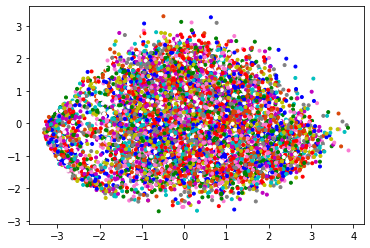

In [116]:


plt.scatter(pca_result[:,0],pca_result[:,1],c=color_arr,marker='.')

plt.show()

### tSNE

In [119]:
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(out)

/Users/simon/Documents/D7047E-AdvancedDeepLearning/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/simon/Documents/D7047E-AdvancedDeepLearning/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


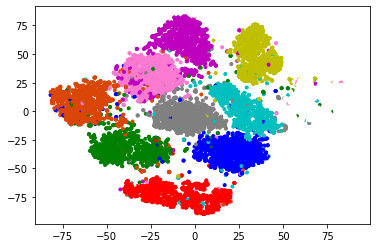

In [120]:
plt.scatter(tsne_result[:,0],tsne_result[:,1],c=color_arr,marker='.')

plt.show()